In [3]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
#import pandas as pd

from IPython.display import display, HTML
import tensorflow as tf
#import numpy as np
#import pandas as pd
#import random as ran
import h5py

import pandas as pd


In [10]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
            for j in range(samples):
                if(dataset[j] > 0):
                    dataset[j] = dataset[j]/maximum
                else:
                    dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array, maximum, minimum


In [121]:
# Split a univariate sequence into samples
#def split_sequence(sequence_noisy,sequence_pure,n_steps):
def split_sequence(sequence_noisy,n_steps):
    X = [] 
#    y = []
    for i in range(len(sequence_noisy)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence_noisy[i:end_ix] 
#        seq_y = sequence_pure[end_ix]
        X.append(seq_x)
#        y.append(seq_y)
#    return array(X), array(y)
    return np.array(X)
    
    
#def reshape_sequences(self, num, data_noisy, data_pure):
def reshape_sequences(num, data_noisy):
    n_steps = 25
    arr_noisy = []
#    arr_pure = []
        
    for i in range(num):
        X_noisy = data_noisy[i]
#        X_pure = data_pure[i]
        X_noisy = np.pad(X_noisy, (n_steps, n_steps), 'constant', constant_values=(0, 0))
#        X_pure = np.pad(X_pure, (n_steps, n_steps), 'constant', constant_values=(0, 0))
        # split into samples
#        X, y = self.split_sequence(X_noisy, X_pure, n_steps)
        X = split_sequence(X_noisy, n_steps)
        arr_noisy.append(X)
#        arr_pure.append(y)
    
    arr_noisy = np.asarray(arr_noisy)
#    arr_pure = np.asarray(arr_pure)
        
#    return arr_noisy, arr_pure
    return arr_noisy


In [18]:
class FractalTanimotoLoss(tf.keras.losses.Loss):
        def __init__(lr, base_lr=2e-3, depth=0, smooth=1e-6, **kwargs):
            depth = depth
            learning_rate = lr
            base_lr = base_lr
            smooth = smooth
            super().__init__(**kwargs)
    
        def inner_prod(self, y, x):
            prod = y*x
            prod = K.sum(prod, axis=1)
        
            return prod
    
        def tnmt_base(x, y, scale):

            tpl  = inner_prod(y,x)
            tpp  = inner_prod(y,y)
            tll  = inner_prod(x,x)


            num = tpl + self.smooth
            denum = 0.0
            result = 0.0
            for d in range(depth):
                a = 2.**d
                b = -(2.*a-1.)

                denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
                
            result =  num * denum * scale
            
            return  result*scale
        
        def call(y_true, y_pred):
            
            if(learning_rate < base_lr):
                depth = depth + 5
                
            depth = depth+1
            scale = 1./len(range(depth))
            
            l1 = K.mean(K.square(y_pred - y_true),axis=-1)
            result = tnmt_base(y_true, y_pred, scale)
        
            return  l1 - 0.01*result
        
        def get_config(self):
            base_config = super().get_config()
            return {**base_config, "depth": depth}   
    

# GW150914

In [4]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW150914_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [5]:
np.where((input_data['#time,'].values > 1126259462.390) & (input_data['#time,'].values < 1126259462.392))[0]


array([17183, 17184, 17185, 17186])

In [6]:
# Lower

17183 -(2048*0.8)

15544.6

In [7]:
# Upper

17183 + (2048*0.2)

17592.6

In [14]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW150914.hdf', 'r')
strain = f1['GW150914-v3']['l1_strain'][()]


In [15]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [19]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [20]:
#from keras.models import load_model
 
# load model
model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2073, 25, 128)    512       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 2073, 25, 128)    5

In [21]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


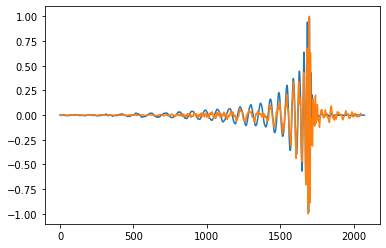

In [22]:
plt.plot(decoded_signals[0])

cwb_reconst = input_data['amp_cwb_point_est,'].values[15545:17593][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])


In [23]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[15545:17593]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[15545:17593]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [25]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O1_real_events/GW150914_reconstruction_CI_dilated_CNN_25_timesteps.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


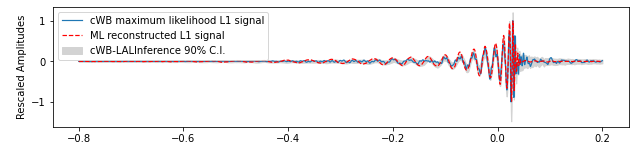

In [26]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW151226 - L1

In [62]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW151226_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [63]:
np.where((input_data['#time,'].values > 1135136350.647) & (input_data['#time,'].values < 1135136350.648))[0]


array([15662, 15663])

In [64]:
# Lower

15662 -(2048*0.8)

14023.6

In [65]:
# Upper

15662 + (2048*0.2)

16071.6

In [66]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW151226.hdf', 'r')
strain = f1['GW151226']['l1_strain'][()]


In [67]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [68]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [69]:
#from keras.models import load_model
 
# load model
model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [70]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


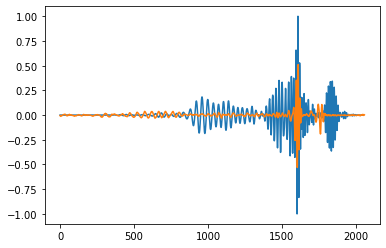

In [71]:
cwb_reconst = input_data['amp_cwb_point_est,'].values[14024:16072][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])

plt.plot(decoded_signals[0])


In [74]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[14024:16072]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[14024:16072]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [75]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O1_real_events/GW151226_reconstruction_CI_dilated_CNN_10_timesteps.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


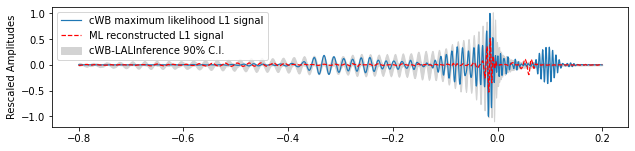

In [76]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW151226 - H1

In [122]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW151226_rec_signal_time_H1.dat",header=0,delimiter=" ")


In [123]:
np.where((input_data['#time,'].values > 1135136350.648) & (input_data['#time,'].values < 1135136350.649))[0]


array([15664, 15665])

In [124]:
# Lower

15664 -(2048*0.8)

14025.6

In [125]:
# Upper

15664 + (2048*0.2)

16073.6

In [126]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW151226.hdf', 'r')
strain = f1['GW151226']['h1_strain'][()]


In [127]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [128]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [129]:
#from keras.models import load_model
 
# load model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2073, 25, 128)    512       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 2073, 25, 128)    5

In [130]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


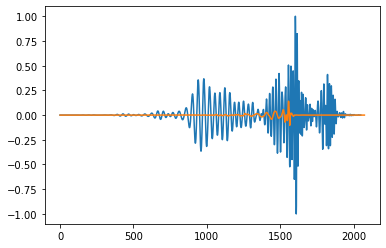

In [131]:
cwb_reconst = input_data['amp_cwb_point_est,'].values[14026:16074][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])

plt.plot(decoded_signals[0])


In [132]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[14026:16074]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[14026:16074]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [133]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O1_real_events/GW151226_reconstruction_CI_dilated_CNN_25_timesteps_H1.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


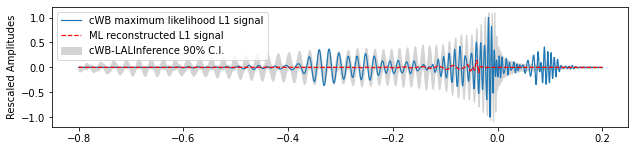

In [134]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)


# GW151012

In [108]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW151012_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [109]:
np.where((input_data['#time,'].values > 1128678900.444) & (input_data['#time,'].values < 1128678900.446))[0]


array([15246, 15247, 15248, 15249])

In [110]:
# Lower

15246 -(2048*0.8)

13607.6

In [111]:
# Upper

15246 + (2048*0.2)

15655.6

In [112]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW151012.hdf', 'r')
strain = f1['GW151012']['l1_strain'][()]


In [113]:
strain = strain[None,:]

strain, maximum, minimum = _preprocess_data(strain, 1, 2048)

strain = np.array(strain)


In [114]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [115]:
#from keras.models import load_model
 
# load model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [116]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


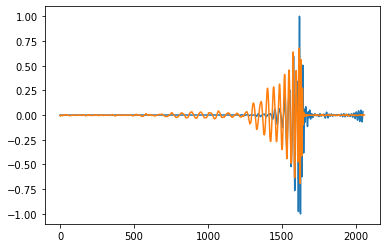

In [117]:
cwb_reconst = input_data['amp_cwb_point_est,'].values[13608:15656][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,2048)

plt.plot(cwb_reconst[0])

plt.plot(decoded_signals[0])


In [118]:
new_lower = []
for value in input_data['amp_pe_post_lower_90_perc,'].values[13608:15656]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_pe_post_upper_90_perc'].values[13608:15656]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [119]:
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90):
    
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O1_real_events/GW151012_reconstruction_CI_dilated_CNN_10_timesteps_L1.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


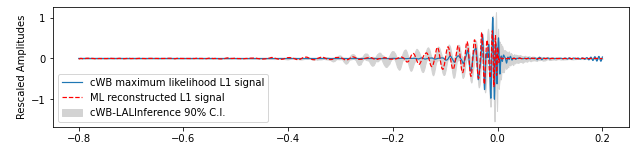

In [120]:
plot_reconstructed(decoded_signals[0][0:2048], np.squeeze(cwb_reconst), new_upper, new_lower)
